## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution 
### with spatial dimension included
### with neighboring luminosities also included

### training on each image separately

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [8]:
def read_labelled_coordinates(kind, scan):
    file = open("../manual_classified_pixels/{0}_coordinates_{1}.txt".format(kind, scan), "r")
    coords = file.readlines()
    file.close()
    coords = np.array([point_from_string(line) for line in coords])
    print("{0}: {1}".format(kind,coords.shape))
    
    return coords

In [9]:
import random

def split_train_test_indices(coords, seed, trrat, kind):
    ind = np.arange(coords.shape[0])
    random.Random(seed).shuffle(ind)
    lim_ind = int(len(ind)*trrat)
    train_ind = ind[:lim_ind]
    test_ind = ind[lim_ind:]
    
    print("{0}: {1} {2}".format(kind, len(train_ind), len(test_ind)))
    
    return train_ind, test_ind

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

def CNN_Model(nwaves):
    Inputs_1 = keras.Input(shape=(nwaves, 1), name="spectra")
    Conv1D_1 = layers.Conv1D(16, kernel_size=(50), padding="same", activation="relu")(Inputs_1)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    Dropout_1 = layers.Dropout(0.5)(MaxPool_2)
    Flatten_1 = layers.Flatten()(Dropout_1)

    Inputs_2 = keras.Input(shape=(2,), name="spatial")
    Inputs_3 = keras.Input(shape=(121,), name="lums")
    Concat = layers.concatenate([Flatten_1, Inputs_2, Inputs_3])
    Dense_1 = layers.Dense(512, activation="relu")(Concat)
    Output = layers.Dense(9, activation="softmax")(Dense_1)

    model = keras.Model(inputs=[Inputs_1, Inputs_2, Inputs_3],
                        outputs=[Output],)
    
    return model

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_history(model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'], loc='center right')
    ax2.plot(model.history['acc'])
    ax2.plot(model.history['val_acc'])
    ax2.set_title('CNN Model Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=12, axis='x')
    ax2.legend(['train', 'test'], loc='center right')
    ax3.plot(model.history['loss'])
    ax3.plot(model.history['val_loss'])
    ax3.set_ylabel('log(loss)')
    ax3.set_xlabel('epoch')
    ax3.locator_params(nbins=13, axis='x')
    ax3.legend(['train', 'test'], loc='center right')
    ax3.set_yscale('log')
    ax4.plot(model.history['acc'])
    ax4.plot(model.history['val_acc'])
    ax4.set_ylabel('log(accuracy)')
    ax4.set_xlabel('epoch')
    ax4.locator_params(nbins=12, axis='x')
    ax4.legend(['train', 'test'], loc='center right')
    ax4.set_yscale('log')
    plt.show()

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [12]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [13]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [14]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


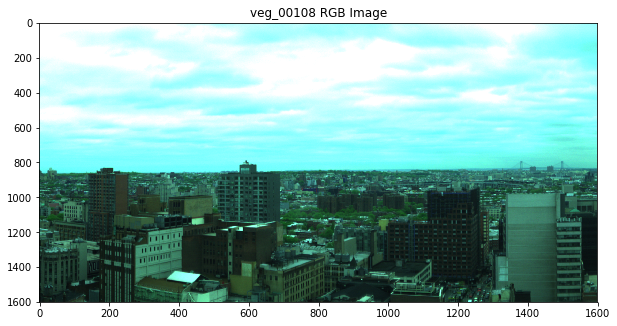

In [15]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

In [15]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
print(cube_standard.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [16]:
sky_coords = read_labelled_coordinates("1_sky", "108")
clouds_coords = read_labelled_coordinates("2_clouds", "108")
veg_coords = read_labelled_coordinates("3_vegetation", "108")
wtr_coords = read_labelled_coordinates("4_water", "108")
blt_coords = read_labelled_coordinates("5_buildings", "108")
windows_coords = read_labelled_coordinates("6_windows", "108")
rds_coords = read_labelled_coordinates("7_roads", "108")
cars_coords = read_labelled_coordinates("8_cars", "108")
mtl_coords = read_labelled_coordinates("9_metal", "108")

1_sky: (300, 2)
2_clouds: (500, 2)
3_vegetation: (600, 2)
4_water: (50, 2)
5_buildings: (1020, 2)
6_windows: (500, 2)
7_roads: (30, 2)
8_cars: (100, 2)
9_metal: (100, 2)


In [17]:
# create position array and normalize

xy = coords(cube_sub.shape[1], cube_sub.shape[2])
xy = xy/xy.max()

#### Calculating Luminosities for the image

In [18]:
xwaves = np.array(cube.waves)
xwaves.shape

(848,)

In [19]:
from numpy import trapz
lums = np.zeros(cube_reshaped.shape[0])
for i in range(cube_reshaped.shape[0]):
    lums[i] = trapz(cube_reshaped[i,:], xwaves)

#from scipy.integrate import simps
#lums = simps(cube_reshaped, cube.waves, axis=-1)

In [20]:
print(lums.shape)
lums_2d = lums.reshape(cube_sub.shape[1], cube_sub.shape[2])
print(lums_2d.shape)

(2560000,)
(1600, 1600)


In [21]:
lums_grid = np.zeros(shape=(cube_sub.shape[1], cube_sub.shape[2], 11, 11))
print(lums_grid.shape)

(1600, 1600, 11, 11)


In [22]:
import itertools
for row, col in itertools.product(np.arange(cube_sub.shape[1]), np.arange(cube_sub.shape[2])):
    i = 0
    for adjrow in np.arange(row-5, row+6):
        if adjrow in np.arange(cube_sub.shape[1]):
            j = 0
            for adjcol in np.arange(col-5, col+6):
                if adjcol in np.arange(cube_sub.shape[2]):
                    lums_grid[row,col,i,j] = lums_2d[adjrow,adjcol]
                j +=1 
        i += 1

#### split classified pixels into 80% training and 20% testing sets

In [24]:
trrat = 0.8
sky_train_ind, sky_test_ind = split_train_test_indices(sky_coords, 0, trrat, "sky")
clouds_train_ind, clouds_test_ind = split_train_test_indices(clouds_coords, 1, trrat, "clouds")
veg_train_ind, veg_test_ind = split_train_test_indices(veg_coords, 2, trrat, "veg")
wtr_train_ind, wtr_test_ind = split_train_test_indices(wtr_coords, 3, trrat, "wtr")
blt_train_ind, blt_test_ind = split_train_test_indices(blt_coords, 4, trrat, "blt")
windows_train_ind, windows_test_ind = split_train_test_indices(windows_coords, 5, trrat, "windows")
rds_train_ind, rds_test_ind = split_train_test_indices(rds_coords, 6, trrat, "rds")
cars_train_ind, cars_test_ind = split_train_test_indices(cars_coords, 7, trrat, "cars")
mtl_train_ind, mtl_test_ind = split_train_test_indices(mtl_coords, 8, trrat, "mtl")

sky: 240 60
clouds: 400 100
veg: 480 120
wtr: 40 10
blt: 816 204
windows: 400 100
rds: 24 6
cars: 80 20
mtl: 80 20


In [25]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
print(cube_std_3d.shape)
print(xy.shape)

(1600, 1600, 848)
(1600, 1600, 2)


In [26]:
cube_sky_train = cube_std_3d[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_3d[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
sky_xy_train = xy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
sky_xy_test = xy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
sky_lums_train = lums_grid[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :, :]
sky_lums_test = lums_grid[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :, :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_3d[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_3d[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
clouds_xy_train = xy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
clouds_xy_test = xy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
clouds_lums_train = lums_grid[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :, :]
clouds_lums_test = lums_grid[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :, :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_3d[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_3d[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
veg_xy_train = xy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
veg_xy_test = xy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
veg_lums_train = lums_grid[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :, :]
veg_lums_test = lums_grid[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :, :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_3d[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_3d[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
wtr_xy_train = xy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
wtr_xy_test = xy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
wtr_lums_train = lums_grid[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :, :]
wtr_lums_test = lums_grid[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :, :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_3d[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_3d[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
blt_xy_train = xy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
blt_xy_test = xy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
blt_lums_train = lums_grid[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :, :]
blt_lums_test = lums_grid[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :, :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_3d[windows_coords[windows_train_ind[:],0], windows_coords[windows_train_ind[:],1],:]
cube_windows_test = cube_std_3d[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
windows_xy_train = xy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
windows_xy_test = xy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
windows_lums_train = lums_grid[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :, :]
windows_lums_test = lums_grid[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :, :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_3d[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_3d[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
rds_xy_train = xy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
rds_xy_test = xy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
rds_lums_train = lums_grid[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :, :]
rds_lums_test = lums_grid[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :, :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_3d[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_3d[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
cars_xy_train = xy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cars_xy_test = xy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
cars_lums_train = lums_grid[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :, :]
cars_lums_test = lums_grid[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :, :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_3d[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_3d[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
mtl_xy_train = xy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
mtl_xy_test = xy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
mtl_lums_train = lums_grid[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :, :]
mtl_lums_test = lums_grid[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :, :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 848) (60, 848)
clouds  (400, 848) (100, 848)
vegetation  (480, 848) (120, 848)
water  (40, 848) (10, 848)
built  (816, 848) (204, 848)
windows  (400, 848) (100, 848)
roads  (24, 848) (6, 848)
cars  (80, 848) (20, 848)
metal  (80, 848) (20, 848)


In [27]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]
xy_train = np.concatenate((sky_xy_train, clouds_xy_train, veg_xy_train, wtr_xy_train, blt_xy_train,
                             windows_xy_train, rds_xy_train, cars_xy_train, mtl_xy_train), axis=0)
lums_train = np.concatenate((sky_lums_train, clouds_lums_train, veg_lums_train, wtr_lums_train, blt_lums_train,
                             windows_lums_train, rds_lums_train, cars_lums_train, mtl_lums_train), axis=0)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]
xy_test = np.concatenate((sky_xy_test, clouds_xy_test, veg_xy_test, wtr_xy_test, blt_xy_test,
                             windows_xy_test, rds_xy_test, cars_xy_test, mtl_xy_test), axis=0)
lums_test = np.concatenate((sky_lums_test, clouds_lums_test, veg_lums_test, wtr_lums_test, blt_lums_test,
                             windows_lums_test, rds_lums_test, cars_lums_test, mtl_lums_test), axis=0)

In [28]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

print(cube_train.shape, cube_train_labels.shape, xy_train.shape, lums_train.shape)
print(cube_test.shape, cube_test_labels.shape, xy_test.shape, lums_test.shape)

(2560, 848) (2560,) (2560, 2) (2560, 11, 11)
(640, 848) (640,) (640, 2) (640, 11, 11)


In [29]:
lums_flat_train = lums_train.reshape(lums_train.shape[0], (lums_train.shape[1]*lums_train.shape[2]))
lums_flat_test = lums_test.reshape(lums_test.shape[0], (lums_test.shape[1]*lums_test.shape[2]))

print(lums_flat_train.shape, lums_flat_test.shape)

(2560, 121) (640, 121)


### Train CNN

In [30]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [31]:
#keras.utils.plot_model(cnn, show_shapes=True)
#cnn.summary()

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

In [41]:
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train, "lums":lums_flat_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test, "lums":lums_flat_test}, 
                                      cube_test_labels),
                     epochs=200, batch_size=512)

Train on 2560 samples, validate on 640 samples
Epoch 1/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 2/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 3/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 4/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 5/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 6/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 7/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0

2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 61/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 62/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 63/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 64/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 65/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 66/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 67/200
2560/2560 [=======================

2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 120/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 121/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 122/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 123/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 124/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 125/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 126/200
2560/2560 [================

2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 179/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 180/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 181/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 182/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 183/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 184/200
2560/2560 [==============================] - 3s 1ms/step - loss: 13.6752 - acc: 0.1516 - val_loss: 13.7508 - val_acc: 0.1469
Epoch 185/200
2560/2560 [================

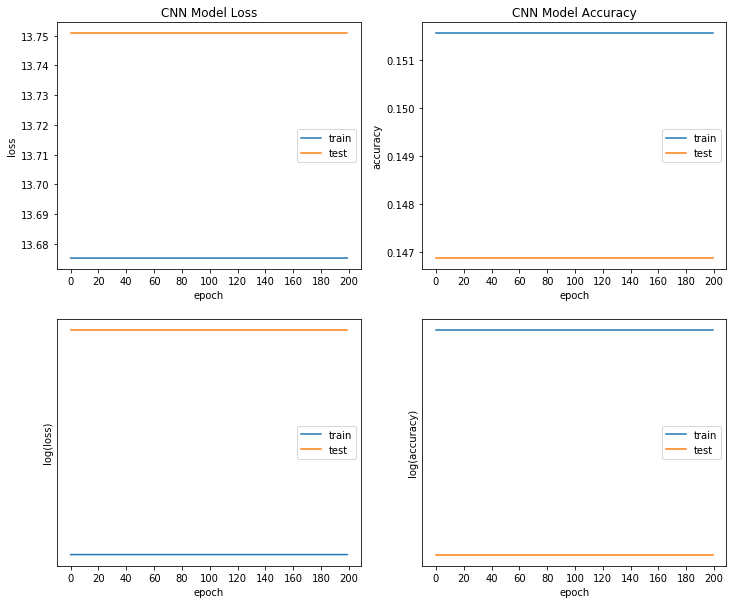

In [42]:
plot_loss_history(CNNmodel)

In [43]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train, "lums":lums_flat_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test, "lums":lums_flat_test}, 
                                      cube_test_labels),
                     epochs=1, batch_size=512)

Train on 2560 samples, validate on 640 samples
Epoch 1/1
2560/2560 [==============================] - 4s 1ms/step - loss: 13.5934 - acc: 0.1566 - val_loss: 13.5493 - val_acc: 0.1594


In [44]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn.evaluate({"spectra":cube_train2, "spatial":xy_train, "lums":lums_flat_train},
                                     cube_train_labels)
test_loss, test_acc = cnn.evaluate({"spectra":cube_test2, "spatial":xy_test, "lums":lums_flat_test}, 
                                   cube_test_labels)

print(train_acc, test_acc)

640/640 [==============================] - 0s 500us/step
0.156640625 0.159375


### Predict pixel classification on veg_00108

In [45]:
cube_standard_1 = cube_standard.reshape(cube_standard.shape[0], cube_standard.shape[1], 1)
print(cube_standard_1.shape)
xy_2d = xy.reshape((xy.shape[0] * xy.shape[1]), xy.shape[2])
print(xy_2d.shape)

(2560000, 848, 1)
(2560000, 2)


In [47]:
lums_grid_flat = lums_grid.reshape((lums_grid.shape[0]*lums_grid.shape[1]), (lums_grid.shape[2]*lums_grid.shape[3]))
print(lums_grid_flat.shape)

(2560000, 121)


In [48]:
# classify entire binned cube
import time
start_time = time.time()

probCube = cnn.predict({"spectra":cube_standard_1, "spatial":xy_2d, "lums":lums_grid_flat})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:22:25


In [49]:
predictCube = probCube.argmax(axis=-1)

In [50]:
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

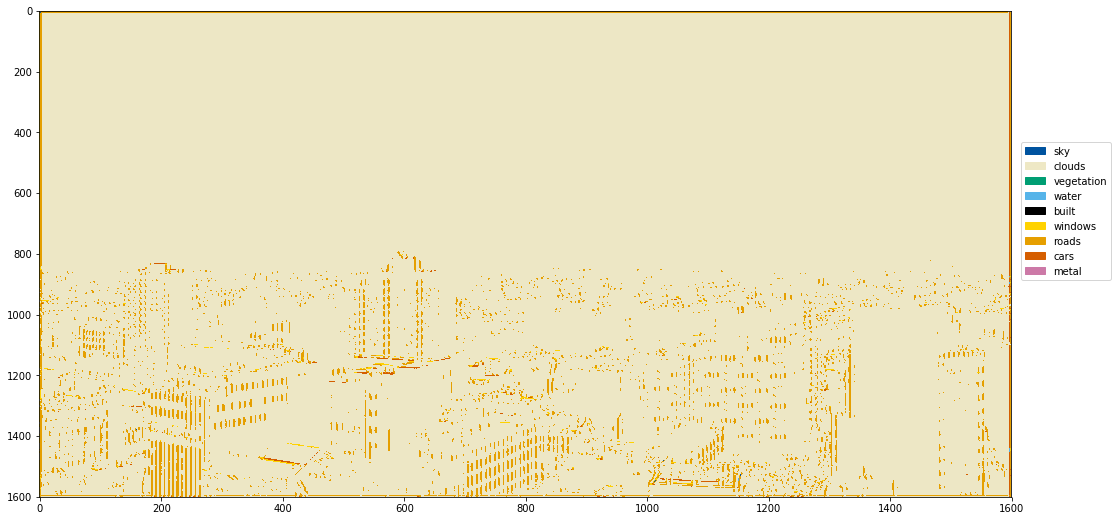

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

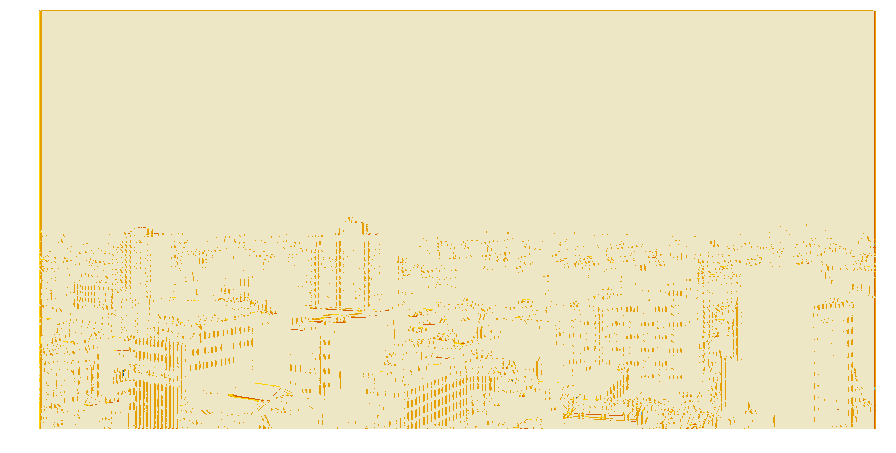

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
#fig.savefig("./plots/CNN_Model2_spatial_train_108_test_108_predict_map.png", bbox_inches='tight')

In [ ]:
#import pickle
#pickle.dump(predictCube_reshape, open("./plots/CNN_Model2_spatial_train_108_test_108_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108)

In [ ]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [ ]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [ ]:
print(labels_pred.shape)
print(labels_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

In [ ]:
#f = open("./metrics/CNN_Model2_spatial_train_108_test_108_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

---
## CNN trained on veg_00000 (Scene 1-b South Facing @ ~6pm)

In [ ]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

In [ ]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

In [ ]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

In [ ]:
cube_norm0 = (cube_reshaped0 - cube_reshaped0.min()) / (cube_reshaped0.max() - cube_reshaped0.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind0 = (np.abs(cube0.waves - 650.0)).argmin()
green_ind0 = (np.abs(cube0.waves - 550.0)).argmin()
blue_ind0 = (np.abs(cube0.waves - 450.0)).argmin()

cube_reshaped02 = cube_norm0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
cube_scene0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 RGB Image')
ax.imshow(cube_scene0, aspect=0.5)
plt.show()

In [ ]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)
print(cube_standard0.shape)

#### Reading manually classified set for training and testing

In [ ]:
sky_coords0 = read_labelled_coordinates("1_sky", "000")
clouds_coords0 = read_labelled_coordinates("2_clouds", "000")
veg_coords0 = read_labelled_coordinates("3_vegetation", "000")
wtr_coords0 = read_labelled_coordinates("4_water", "000")
blt_coords0 = read_labelled_coordinates("5_buildings", "000")
windows_coords0 = read_labelled_coordinates("6_windows", "000")
rds_coords0 = read_labelled_coordinates("7_roads", "000")
cars_coords0 = read_labelled_coordinates("8_cars", "000")
mtl_coords0 = read_labelled_coordinates("9_metal", "000")

In [ ]:
# create position array and normalize

xy0 = coords(cube_sub0.shape[1], cube_sub0.shape[2])
xy0 = xy0/xy0.max()

#### split classified pixels into 80% training and 20% testing sets

In [ ]:
trrat = 0.8
sky_train_ind0, sky_test_ind0 = split_train_test_indices(sky_coords0, 10, trrat, "sky")
clouds_train_ind0, clouds_test_ind0 = split_train_test_indices(clouds_coords0, 20, trrat, "clouds")
veg_train_ind0, veg_test_ind0 = split_train_test_indices(veg_coords0, 30, trrat, "veg")
#wtr_train_ind0, wtr_test_ind0 = split_train_test_indices(wtr_coords0, 40, trrat, "wtr")
blt_train_ind0, blt_test_ind0 = split_train_test_indices(blt_coords0, 50, trrat, "blt")
windows_train_ind0, windows_test_ind0 = split_train_test_indices(windows_coords0, 60, trrat, "windows")
rds_train_ind0, rds_test_ind0 = split_train_test_indices(rds_coords0, 70, trrat, "rds")
cars_train_ind0, cars_test_ind0 = split_train_test_indices(cars_coords0, 80, trrat, "cars")
mtl_train_ind0, mtl_test_ind0 = split_train_test_indices(mtl_coords0, 90, trrat, "mtl")

In [ ]:
cube_std0_3d = cube_standard0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
print(cube_std0_3d.shape)
print(xy0.shape)

In [ ]:
cube_sky_train0 = cube_std0_3d[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
cube_sky_test0 = cube_std0_3d[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
sky_xy_train0 = xy0[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
sky_xy_test0 = xy0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
print("sky ", cube_sky_train0.shape, cube_sky_test0.shape)

cube_clouds_train0 = cube_std0_3d[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
cube_clouds_test0 = cube_std0_3d[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
clouds_xy_train0 = xy0[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
clouds_xy_test0 = xy0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
print("clouds ", cube_clouds_train0.shape, cube_clouds_test0.shape)

cube_veg_train0 = cube_std0_3d[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
cube_veg_test0 = cube_std0_3d[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
veg_xy_train0 = xy0[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
veg_xy_test0 = xy0[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
print("vegetation ", cube_veg_train0.shape, cube_veg_test0.shape)

#cube_wtr_train0 = cube_std0_3d[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#cube_wtr_test0 = cube_std0_3d[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#wtr_xy_train0 = xy0[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#wtr_xy_test0 = xy0[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#print("water ", cube_wtr_train0.shape, cube_wtr_test0.shape)

cube_blt_train0 = cube_std0_3d[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
cube_blt_test0 = cube_std0_3d[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
blt_xy_train0 = xy0[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
blt_xy_test0 = xy0[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
print("built ", cube_blt_train0.shape, cube_blt_test0.shape)

cube_windows_train0 = cube_std0_3d[windows_coords0[windows_train_ind0[:],0], windows_coords0[windows_train_ind0[:],1],:]
cube_windows_test0 = cube_std0_3d[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
windows_xy_train0 = xy0[windows_coords0[windows_train_ind0[:], 0], windows_coords0[windows_train_ind0[:], 1], :]
windows_xy_test0 = xy0[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
print("windows ", cube_windows_train0.shape, cube_windows_test0.shape)

cube_rds_train0 = cube_std0_3d[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
cube_rds_test0 = cube_std0_3d[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
rds_xy_train0 = xy0[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
rds_xy_test0 = xy0[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
print("roads ", cube_rds_train0.shape, cube_rds_test0.shape)

cube_cars_train0 = cube_std0_3d[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cube_cars_test0 = cube_std0_3d[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
cars_xy_train0 = xy0[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cars_xy_test0 = xy0[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
print("cars ", cube_cars_train0.shape, cube_cars_test0.shape)

cube_mtl_train0 = cube_std0_3d[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
cube_mtl_test0 = cube_std0_3d[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
mtl_xy_train0 = xy0[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
mtl_xy_test0 = xy0[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
print("metal ", cube_mtl_train0.shape, cube_mtl_test0.shape)

In [ ]:
cube_train0 = np.concatenate((cube_sky_train0, cube_clouds_train0, cube_veg_train0, cube_blt_train0,
                             cube_windows_train0, cube_rds_train0, cube_cars_train0, cube_mtl_train0), axis=0)
cube_train_labels0 = [0]*cube_sky_train0.shape[0] + [1]*cube_clouds_train0.shape[0] \
                + [2]*cube_veg_train0.shape[0] + [4]*cube_blt_train0.shape[0] \
                + [5]*cube_windows_train0.shape[0] + [6]*cube_rds_train0.shape[0] \
                + [7]*cube_cars_train0.shape[0] + [8]*cube_mtl_train0.shape[0]
xy_train0 = np.concatenate((sky_xy_train0, clouds_xy_train0, veg_xy_train0, blt_xy_train0,
                             windows_xy_train0, rds_xy_train0, cars_xy_train0, mtl_xy_train0), axis=0)

cube_test0 = np.concatenate((cube_sky_test0, cube_clouds_test0, cube_veg_test0, cube_blt_test0,
                             cube_windows_test0, cube_rds_test0, cube_cars_test0, cube_mtl_test0), axis=0)
cube_test_labels0 = [0]*cube_sky_test0.shape[0] + [1]*cube_clouds_test0.shape[0] \
                + [2]*cube_veg_test0.shape[0] + [4]*cube_blt_test0.shape[0] \
                + [5]*cube_windows_test0.shape[0] + [6]*cube_rds_test0.shape[0] \
                + [7]*cube_cars_test0.shape[0] + [8]*cube_mtl_test0.shape[0]
xy_test0 = np.concatenate((sky_xy_test0, clouds_xy_test0, veg_xy_test0, blt_xy_test0,
                             windows_xy_test0, rds_xy_test0, cars_xy_test0, mtl_xy_test0), axis=0)

In [ ]:
cube_train_labels0 = np.array(cube_train_labels0)
cube_test_labels0 = np.array(cube_test_labels0)

print(cube_train0.shape, cube_train_labels0.shape, xy_train0.shape)
print(cube_test0.shape, cube_test_labels0.shape, xy_test0.shape)

### Train CNN

In [ ]:
cnn0 = CNN_Model(cube_std0_3d.shape[2])
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
#keras.utils.plot_model(cnn0, show_shapes=True)
#cnn0.summary()

cube_train02 = cube_train0.reshape(cube_train0.shape[0], cube_train0.shape[1], 1)
cube_test02 = cube_test0.reshape(cube_test0.shape[0], cube_test0.shape[1], 1)

In [ ]:
CNNmodel0 = cnn0.fit({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0),
                     epochs=200, batch_size=512)

In [ ]:
plot_loss_history(CNNmodel0)

In [ ]:
cnn0 = CNN_Model(cube_std0_3d.shape[2])
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel0 = cnn0.fit({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0),
                     epochs=100, batch_size=512)

In [ ]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn0.evaluate({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0)
test_loss, test_acc = cnn0.evaluate({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0)

print(train_acc, test_acc)

### Predict pixel classification on veg_00000

In [ ]:
cube_standard0_1 = cube_standard0.reshape(cube_standard0.shape[0], cube_standard0.shape[1], 1)
print(cube_standard0_1.shape)
xy0_2d = xy0.reshape((xy0.shape[0] * xy0.shape[1]), xy0.shape[2])
print(xy0_2d.shape)

In [ ]:
# classify entire binned cube
import time
start_time = time.time()

probCube0 = cnn0.predict({"spectra":cube_standard0_1, "spatial":xy0_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
predictCube0 = probCube0.argmax(axis=-1)

In [ ]:
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_3_000_predict_map.png", 
#bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_000_test_000_predict_map.png", bbox_inches='tight', dpi=300)

In [ ]:
import pickle
pickle.dump(predictCube_reshape0, open("./plots/CNN_Model2_spatial_train_000_test_000_predict_map.pickle", "wb"))

In [ ]:
wtr_coords0=np.array([[0,0]])

### Evaluation Metrics (veg_00000)

In [ ]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:],1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[veg_test_ind0[:],0], veg_coords0[veg_test_ind0[:],1]]
#labels0_pred_wtr = predictCube_reshape0[wtr_coords0[wtr_test_ind0[:],0], wtr_coords0[wtr_test_ind0[:],1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[blt_test_ind0[:],0], blt_coords0[blt_test_ind0[:],1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[windows_test_ind0[:],0], windows_coords0[windows_test_ind0[:],1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[rds_test_ind0[:],0], rds_coords0[rds_test_ind0[:],1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[cars_test_ind0[:],0], cars_coords0[cars_test_ind0[:],1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[mtl_test_ind0[:],0], mtl_coords0[mtl_test_ind0[:],1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, #labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, 
                               labels0_pred_cars, labels0_pred_mtl))

In [ ]:
labels0_true_sky = np.full(len(sky_test_ind0), 0)
labels0_true_clouds = np.full(len(clouds_test_ind0), 1)
labels0_true_veg = np.full(len(veg_test_ind0), 2)
#labels0_true_wtr = np.full(len(wtr_test_ind0), 3)
labels0_true_blt = np.full(len(blt_test_ind0), 4)
labels0_true_windows = np.full(len(windows_test_ind0), 5)
labels0_true_rds = np.full(len(rds_test_ind0), 6)
labels0_true_cars = np.full(len(cars_test_ind0), 7)
labels0_true_mtl = np.full(len(mtl_test_ind0), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, #labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [ ]:
print(labels0_pred.shape)
print(labels0_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

In [ ]:
f = open("./metrics/CNN_Model2_spatial_train_000_test_000_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

---
## CNN trained on North Facing Image

In [ ]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

In [ ]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

In [ ]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

In [ ]:
cube_norm_north = (cube_reshaped_north - cube_reshaped_north.min()) / (cube_reshaped_north.max() - cube_reshaped_north.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind_n = (np.abs(cube_north.waves - 650.0)).argmin()
green_ind_n = (np.abs(cube_north.waves - 550.0)).argmin()
blue_ind_n = (np.abs(cube_north.waves - 450.0)).argmin()

cube_reshaped_north2 = cube_norm_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
cube_scene_north = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing RGB Image')
ax.imshow(cube_scene_north, aspect=0.4)
plt.show()

In [ ]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
print(cube_standard_north.shape)

#### Reading manually classified set for training and testing

In [ ]:
sky_coordsn = read_labelled_coordinates("1_sky", "north")
clouds_coordsn = read_labelled_coordinates("2_clouds", "north")
veg_coordsn = read_labelled_coordinates("3_vegetation", "north")
wtr_coordsn = read_labelled_coordinates("4_water", "north")
blt_coordsn = read_labelled_coordinates("5_buildings", "north")
windows_coordsn = read_labelled_coordinates("6_windows", "north")
rds_coordsn = read_labelled_coordinates("7_roads", "north")
cars_coordsn = read_labelled_coordinates("8_cars", "north")
mtl_coordsn = read_labelled_coordinates("9_metal", "north")

In [ ]:
xyn = coords(cube_sub_north.shape[1], cube_sub_north.shape[2])
xyn = xyn/xyn.max()

#### split classified pixels into 80% training and 20% testing sets

In [ ]:
trrat = 0.8
sky_train_indn, sky_test_indn = split_train_test_indices(sky_coordsn, 100, trrat, "sky")
clouds_train_indn, clouds_test_indn = split_train_test_indices(clouds_coordsn, 200, trrat, "clouds")
veg_train_indn, veg_test_indn = split_train_test_indices(veg_coordsn, 300, trrat, "veg")
wtr_train_indn, wtr_test_indn = split_train_test_indices(wtr_coordsn, 400, trrat, "wtr")
blt_train_indn, blt_test_indn = split_train_test_indices(blt_coordsn, 500, trrat, "blt")
windows_train_indn, windows_test_indn = split_train_test_indices(windows_coordsn, 600, trrat, "windows")
rds_train_indn, rds_test_indn = split_train_test_indices(rds_coordsn, 700, trrat, "rds")
cars_train_indn, cars_test_indn = split_train_test_indices(cars_coordsn, 800, trrat, "cars")
mtl_train_indn, mtl_test_indn = split_train_test_indices(mtl_coordsn, 900, trrat, "mtl")

In [ ]:
cube_stdn_3d = cube_standard_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
print(cube_stdn_3d.shape)
print(xyn.shape)

In [ ]:
cube_sky_trainn = cube_stdn_3d[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
cube_sky_testn = cube_stdn_3d[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
sky_xy_trainn = xyn[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
sky_xy_testn = xyn[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
print("sky ", cube_sky_trainn.shape, cube_sky_testn.shape)

cube_clouds_trainn = cube_stdn_3d[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
cube_clouds_testn = cube_stdn_3d[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
clouds_xy_trainn = xyn[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
clouds_xy_testn = xyn[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
print("clouds ", cube_clouds_trainn.shape, cube_clouds_testn.shape)

cube_veg_trainn = cube_stdn_3d[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
cube_veg_testn = cube_stdn_3d[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
veg_xy_trainn = xyn[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
veg_xy_testn = xyn[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
print("vegetation ", cube_veg_trainn.shape, cube_veg_testn.shape)

cube_wtr_trainn = cube_stdn_3d[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
cube_wtr_testn = cube_stdn_3d[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
wtr_xy_trainn = xyn[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
wtr_xy_testn = xyn[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
print("water ", cube_wtr_trainn.shape, cube_wtr_testn.shape)

cube_blt_trainn = cube_stdn_3d[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
cube_blt_testn = cube_stdn_3d[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
blt_xy_trainn = xyn[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
blt_xy_testn = xyn[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
print("built ", cube_blt_trainn.shape, cube_blt_testn.shape)

cube_windows_trainn = cube_stdn_3d[windows_coordsn[windows_train_indn[:],0], windows_coordsn[windows_train_indn[:],1],:]
cube_windows_testn = cube_stdn_3d[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
windows_xy_trainn = xyn[windows_coordsn[windows_train_indn[:], 0], windows_coordsn[windows_train_indn[:], 1], :]
windows_xy_testn = xyn[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
print("windows ", cube_windows_trainn.shape, cube_windows_testn.shape)

cube_rds_trainn = cube_stdn_3d[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
cube_rds_testn = cube_stdn_3d[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
rds_xy_trainn = xyn[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
rds_xy_testn = xyn[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
print("roads ", cube_rds_trainn.shape, cube_rds_testn.shape)

cube_cars_trainn = cube_stdn_3d[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cube_cars_testn = cube_stdn_3d[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
cars_xy_trainn = xyn[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cars_xy_testn = xyn[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
print("cars ", cube_cars_trainn.shape, cube_cars_testn.shape)

cube_mtl_trainn = cube_stdn_3d[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
cube_mtl_testn = cube_stdn_3d[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
mtl_xy_trainn = xyn[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
mtl_xy_testn = xyn[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
print("metal ", cube_mtl_trainn.shape, cube_mtl_testn.shape)

In [ ]:
# concatenate training and testing sets and create index arrays

cube_trainn = np.concatenate((cube_sky_trainn, cube_clouds_trainn, cube_veg_trainn, cube_wtr_trainn, cube_blt_trainn, 
                            cube_windows_trainn, cube_rds_trainn, cube_cars_trainn, cube_mtl_trainn), axis=0)
cube_train_labelsn = [0]*cube_sky_trainn.shape[0] + [1]*cube_clouds_trainn.shape[0] \
                    + [2]*cube_veg_trainn.shape[0] + [3]*cube_wtr_trainn.shape[0] + [4]*cube_blt_trainn.shape[0] \
                    + [5]*cube_windows_trainn.shape[0] + [6]*cube_rds_trainn.shape[0] \
                    + [7]*cube_cars_trainn.shape[0] + [8]*cube_mtl_trainn.shape[0]
xy_trainn = np.concatenate((sky_xy_trainn, clouds_xy_trainn, veg_xy_trainn, wtr_xy_trainn, blt_xy_trainn,
                             windows_xy_trainn, rds_xy_trainn, cars_xy_trainn, mtl_xy_trainn), axis=0)

cube_testn = np.concatenate((cube_sky_testn, cube_clouds_testn, cube_veg_testn, cube_wtr_testn, cube_blt_testn, 
                            cube_windows_testn, cube_rds_testn, cube_cars_testn, cube_mtl_testn), axis=0)
cube_test_labelsn = [0]*cube_sky_testn.shape[0] + [1]*cube_clouds_testn.shape[0] \
                    + [2]*cube_veg_testn.shape[0] + [3]*cube_wtr_testn.shape[0] + [4]*cube_blt_testn.shape[0] \
                    + [5]*cube_windows_testn.shape[0] + [6]*cube_rds_testn.shape[0] \
                    + [7]*cube_cars_testn.shape[0] + [8]*cube_mtl_testn.shape[0]
xy_testn = np.concatenate((sky_xy_testn, clouds_xy_testn, veg_xy_testn, wtr_xy_testn, blt_xy_testn, 
                             windows_xy_testn, rds_xy_testn, cars_xy_testn, mtl_xy_testn), axis=0)

In [ ]:
cube_train_labelsn = np.array(cube_train_labelsn)
cube_test_labelsn = np.array(cube_test_labelsn)

print(cube_trainn.shape, cube_train_labelsn.shape, xy_trainn.shape)
print(cube_testn.shape, cube_test_labelsn.shape, xy_testn.shape)

#### Train CNN

In [ ]:
cnnn = CNN_Model(cube_stdn_3d.shape[2])
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
#keras.utils.plot_model(cnnn, show_shapes=True)
#cnnn.summary()

cube_trainn2 = cube_trainn.reshape(cube_trainn.shape[0], cube_trainn.shape[1], 1)
cube_testn2 = cube_testn.reshape(cube_testn.shape[0], cube_testn.shape[1], 1)

In [ ]:
CNNmodeln = cnnn.fit({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn),
                     epochs=200, batch_size=512)

In [ ]:
plot_loss_history(CNNmodeln)

In [ ]:
cnnn = CNN_Model(cube_stdn_3d.shape[2])
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodeln = cnnn.fit({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn),
                     epochs=70, batch_size=512)

In [ ]:
# model accuracy on training and testing sets

train_loss, train_acc = cnnn.evaluate({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn)
test_loss, test_acc = cnnn.evaluate({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn)

print(train_acc, test_acc)

### Predict pixel classification on north facing image

In [ ]:
cube_standardn_1 = cube_standard_north.reshape(cube_standard_north.shape[0], cube_standard_north.shape[1], 1)
print(cube_standardn_1.shape)
xyn_2d = xyn.reshape((xyn.shape[0] * xyn.shape[1]), xyn.shape[2])
print(xyn_2d.shape)

In [ ]:
# classify entire binned cube
import time
start_time = time.time()

probCuben = cnnn.predict({"spectra":cube_standardn_1, "spatial":xyn_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
predictCuben = probCuben.argmax(axis=-1)

In [ ]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_5_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.4)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_north_test_north_predict_map.png", bbox_inches='tight', dpi=300)

In [ ]:
import pickle
pickle.dump(predictCube_reshapen, open("./plots/CNN_Model2_spatial_train_north_test_north_predict_map.pickle", "wb"))

### Evaluation Metrics (north facing)

In [ ]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:],1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[veg_test_indn[:],0], veg_coordsn[veg_test_indn[:],1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[wtr_test_indn[:],0], wtr_coordsn[wtr_test_indn[:],1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[blt_test_indn[:],0], blt_coordsn[blt_test_indn[:],1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[windows_test_indn[:],0], windows_coordsn[windows_test_indn[:],1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[rds_test_indn[:],0], rds_coordsn[rds_test_indn[:],1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[cars_test_indn[:],0], cars_coordsn[cars_test_indn[:],1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[mtl_test_indn[:],0], mtl_coordsn[mtl_test_indn[:],1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [ ]:
labelsn_true_sky = np.full(len(sky_test_indn), 0)
labelsn_true_clouds = np.full(len(clouds_test_indn), 1)
labelsn_true_veg = np.full(len(veg_test_indn), 2)
labelsn_true_wtr = np.full(len(wtr_test_indn), 3)
labelsn_true_blt = np.full(len(blt_test_indn), 4)
labelsn_true_windows = np.full(len(windows_test_indn), 5)
labelsn_true_rds = np.full(len(rds_test_indn), 6)
labelsn_true_cars = np.full(len(cars_test_indn), 7)
labelsn_true_mtl = np.full(len(mtl_test_indn), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [ ]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

In [ ]:
f = open("./metrics/CNN_Model2_spatial_train_north_test_north_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()

### CNN Features

In [ ]:
cnn.summary()

In [ ]:
# save filter shapes of convolutional layers to files
filterfiles = ['./CNN_features/CNN_Model2_1a_Conv1D_1_filters.npy',
               './CNN_features/CNN_Model2_1a_Conv1D_2_filters.npy']
biasfiles = ['./CNN_features/CNN_Model2_1a_Conv1D_1_biases.npy',
             './CNN_features/CNN_Model2_1a_Conv1D_2_biases.npy']

i = 0
for layer in cnn.layers:
    if 'conv' in layer.name:
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape, biases.shape)
        np.save(filterfiles[i], filters)
        np.save(biasfiles[i], biases)
        i += 1

In [ ]:
print(biases)

In [ ]:
plt.plot(cube_std_3d[1100,800,:])

In [ ]:
# write vegetation spectrum example to file
np.save('./CNN_features/1a_vegetation_spectrum_example.npy', cube_std_3d[1100,800,:])

In [ ]:
output1 = [cnn.layers[1].output]
submodel1 = keras.Model(inputs=cnn.inputs, outputs=output1)

In [ ]:
x1 = 1100
y1 = 800
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[1100/1600, 800/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_veg_output.npy', featuremap1)

In [ ]:
output2 = [cnn.layers[3].output]
submodel2 = keras.Model(inputs=cnn.inputs, outputs=output2)

In [ ]:
x1 = 1100
y1 = 800
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[1100/1600, 800/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_veg_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[1200,1400,:])

In [ ]:
# write building spectrum example to file
np.save('./CNN_features/1a_building_spectrum_example.npy', cube_std_3d[1200,1400,:])

In [ ]:
output1 = [cnn.layers[1].output]
submodel1 = keras.Model(inputs=cnn.inputs, outputs=output1)

In [ ]:
x1 = 1200
y1 = 1400
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_bld_output.npy', featuremap1)

In [ ]:
output2 = [cnn.layers[3].output]
submodel2 = keras.Model(inputs=cnn.inputs, outputs=output2)

In [ ]:
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_bld_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[353,1266,:])

In [ ]:
np.save('./CNN_features/1a_sky_spectrum_example.npy', cube_std_3d[353,1266,:])

In [ ]:
x1 = 353
y1 = 1266
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_sky_output.npy', featuremap1)

In [ ]:
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_sky_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[230,1172,:])

In [ ]:
np.save('./CNN_features/1a_cloud_spectrum_example.npy', cube_std_3d[230,1172,:])

In [ ]:
x1 = 230
y1 = 1172
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_cloud_output.npy', featuremap1)

specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_cloud_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[837,1453,:])

In [ ]:
np.save('./CNN_features/1a_water_spectrum_example.npy', cube_std_3d[837,1453,:])

In [ ]:
x1 = 837
y1 = 1453
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_water_output.npy', featuremap1)

specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_water_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[1271,1203,:])

In [ ]:
np.save('./CNN_features/1a_window_spectrum_example.npy', cube_std_3d[1271,1203,:])

In [ ]:
x1 = 1271
y1 = 1203
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_window_output.npy', featuremap1)

specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_window_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[1522,1288,:])

In [ ]:
np.save('./CNN_features/1a_road_spectrum_example.npy', cube_std_3d[1522,1288,:])

In [ ]:
x1 = 1522
y1 = 1288
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_road_output.npy', featuremap1)

specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_road_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[1591,1250,:])

In [ ]:
np.save('./CNN_features/1a_car_spectrum_example.npy', cube_std_3d[1591,1250,:])

In [ ]:
x1 = 1591
y1 = 1250
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_car_output.npy', featuremap1)

specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_car_output.npy', featuremap2)

In [ ]:
plt.plot(cube_std_3d[1322,710,:])

In [ ]:
np.save('./CNN_features/1a_metal_spectrum_example.npy', cube_std_3d[1322,710,:])

In [ ]:
x1 = 1322
y1 = 710
specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap1 = submodel1.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap1.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_1_metal_output.npy', featuremap1)

specinput = cube_std_3d[x1,y1,:].reshape(1, cube_std_3d[x1,y1,:].shape[0], 1)
xyinput = np.array([[x1/1600, y1/1600]])
featuremap2 = submodel2.predict({"spectra":specinput, "spatial":xyinput})
print(featuremap2.shape)
np.save('./CNN_features/CNN_Model2_1a_Conv1D_2_metal_output.npy', featuremap2)

In [ ]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(14, 10))
ax1.plot(cube.waves, cube_standard[np.where(predictCube == 0)].T, color=[0,0,0,1], lw=0.001)
ax1.plot(cube.waves, cube_sky_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax1.plot(cube.waves, cube_sky_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax1.text(900, 2, 'sky')
ax1.set_ylabel('amplitude')
ax1.set_ylim(-2, 3)

ax2.plot(cube.waves, cube_standard[np.where(predictCube == 1)].T, color=[0,0,0,1], lw=0.001)
ax2.plot(cube.waves, cube_clouds_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax2.plot(cube.waves, cube_clouds_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax2.text(850, 2, 'clouds')
ax2.set_ylim(-2, 3)

ax3.plot(cube.waves, cube_standard[np.where(predictCube == 2)].T, color=[0,0,0,1], lw=0.001)
ax3.plot(cube.waves, cube_veg_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax3.plot(cube.waves, cube_veg_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax3.text(800, 2, 'vegetation')
ax3.set_ylim(-2, 3)

ax4.plot(cube.waves, cube_standard[np.where(predictCube == 3)].T, color=[0,0,0,1], lw=0.001)
ax4.plot(cube.waves, cube_wtr_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax4.plot(cube.waves, cube_wtr_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax4.text(850, 2, 'water')
ax4.set_ylabel('amplitude')
ax4.set_ylim(-2, 3)

ax5.plot(cube.waves, cube_standard[np.where(predictCube == 4)].T, color=[0,0,0,1], lw=0.001)
ax5.plot(cube.waves, cube_blt_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax5.plot(cube.waves, cube_blt_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax5.text(870, 2, 'built')
ax5.set_ylim(-2, 3)

ax6.plot(cube.waves, cube_standard[np.where(predictCube == 5)].T, color=[0,0,0,1], lw=0.001)
ax6.plot(cube.waves, cube_windows_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax6.plot(cube.waves, cube_windows_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax6.text(800, 2, 'windows')
ax6.set_ylim(-2, 3)

ax7.plot(cube.waves, cube_standard[np.where(predictCube == 6)].T, color=[0,0,0,1], lw=0.1)
ax7.plot(cube.waves, cube_rds_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax7.plot(cube.waves, cube_rds_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax7.text(850, 2, 'roads')
ax7.set_xlabel('wavelength (nm)')
ax7.set_ylabel('amplitude')
ax7.set_ylim(-2, 3)

ax8.plot(cube.waves, cube_standard[np.where(predictCube == 7)].T, color=[0,0,0,1], lw=0.001)
ax8.plot(cube.waves, cube_cars_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax8.plot(cube.waves, cube_cars_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax8.set_xlabel('wavelength (nm)')
ax8.text(900, 2, 'cars')
ax8.set_ylim(-2, 3)

ax9.plot(cube.waves, cube_standard[np.where(predictCube == 8)].T, color=[0,0,0,1], lw=0.001)
ax9.plot(cube.waves, cube_mtl_train.mean(0), color=[1,0.82353,0,1], lw=3, ls='dashed')
ax9.plot(cube.waves, cube_mtl_test.mean(0), color=[0.33725,0.70588,0.91373,1], lw=1)
ax9.set_xlabel('wavelength (nm)')
ax9.text(850, 2, 'metal')
ax9.set_ylim(-2, 3)

legend_elements = [Line2D([0], [0], color=[1,0.82353,0,1], lw=3, ls='dashed', label='mean training set'),
                  Line2D([0], [0], color=[0.33725,0.70588,0.91373,1], lw=2, label='mean testing set'),
                  Line2D([0], [0], color=[0,0,0,1], lw=1, label='labelled by model')]
ax6.legend(handles=legend_elements, loc='center right', borderaxespad=-13, facecolor='white'
           ,edgecolor='black', framealpha=1)
plt.show()
#f.savefig("./plots/CNN_change_params_spatial_train_108_7_108_spectra_train_test_predict_3x3.png", bbox_inches='tight',
#         dpi=300)

In [ ]:
f.savefig("./plots/CNN_Model2_spatial_train_108_test_108_spectra_train_test_predict_3x3.png", 
          bbox_inches='tight', dpi=300)